In [2]:
## path to datasets
datadir='../Datasets/'

In [4]:

import igraph as ig #igraph is a library collection for creating and manipulating graphs and analyzing networks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf

### Question 1 
### (P) Perform a similar type of EDA as in Section 1.12 (in particular,regenerate Table 1.1) on the 1,000 node ABCD graph. Data (edgelist) can be found inDatasets/ABCD/abcd1000.dat on the GitHubrepo.

In [5]:
## read the ABCD data into dataframe
D = pd.read_csv(datadir+'ABCD/abcd_1000.dat')
# split the single column into two columns and then convert it into a dataframe
D = D["411 \t 944"].str.split(expand = True)
D = pd.DataFrame(D)
tuples = [tuple(x) for x in D.values]
# create graph with the tuples
gh = ig.Graph.TupleList(tuples, directed = False)

In [6]:
#basis stats in the table
S = []
deg = gh.degree()
S.append(['ABCD',gh.vcount(),gh.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
      np.max(deg),gh.diameter(),np.max(gh.clusters().membership)+1,gh.clusters().giant().vcount(),
         sum([x==0 for x in gh.degree()]),gh.transitivity_undirected(),gh.transitivity_avglocal_undirected()])

In [7]:
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$'])
D = D.transpose()
D

,0
graph,ABCD
nodes,1000
edges,8326
$d_{min}$,9
$d_{mean}$,16.652
$d_{median}$,13
$d_{quant_{99}}$,62.01
$d_{max}$,92
diameter,4
components,1


### Question 2  
### (P) The link1to the Grid network (Europe) has also data for NorthAmerica.  Perform  a  similar  type  of  EDA  as  in  Section  1.12  (inparticular, regenerate Table 1.1) for that graph, including getting and preparing the data which is usually the most time consumingpart of the process. The raw downloaded  files can be also found inDatasets/GridNorthAmericaon the GitHub repo. You can look at the raw  files and the processed data inDatasets/GridEuropeanddo the same for North America

In [8]:
## read edge list for the NorthAmerica grid network
A = pd.read_csv(datadir+'gridkit_north_america/gridkit_north_america-highvoltage-links.csv')
#A.head()
df_na = A[['v_id_1', 'v_id_2']]
#df_na.head
tuples = [tuple(x) for x in df_na.values]
gr = ig.Graph.TupleList(tuples, directed = False)

In [9]:
## read the vertices along with some attributes
B = pd.read_csv(datadir+'gridkit_north_america/gridkit_north_america-highvoltage-vertices.csv')
B.head()

idx = [int(i) for i in gr.vs['name']]

sorterIndex = dict(zip(idx,range(len(idx))))
B['Rank'] = B['v_id'].map(sorterIndex)

B.sort_values(['Rank'], ascending=[True],inplace=True)
B.dropna(inplace=True)
gr.vs['longitude'] = list(B['lon'])
gr.vs['latitude'] = list(B['lat'])
gr.vs['type'] = list(B['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()]
gr.vs['size'] = 3
gr.es['color'] = 'green'
gr.vs['color'] = 'yellow'
#B.head()

#### Features for North America Grid

In [10]:
F = []
deg = gr.degree()

F.append(['Grid',gr.vcount(),gr.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
      np.max(deg),gr.diameter(),np.max(gr.clusters().membership)+1,gr.clusters().giant().vcount(),
         sum([x==0 for x in gr.degree()]),gr.transitivity_undirected(),gr.transitivity_avglocal_undirected()])

In [11]:
D = pd.DataFrame(F,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$'])
D = D.transpose()
D

,0
graph,Grid
nodes,16167
edges,22459
$d_{min}$,1
$d_{mean}$,2.77838
$d_{median}$,3
$d_{quant_{99}}$,9
$d_{max}$,27
diameter,138
components,34


#### Visualize part of the North America Grid network

4088 nodes


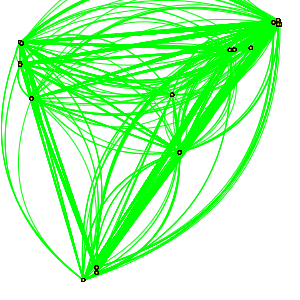

In [12]:
V = [v for v in gr.vs() if v['latitude']>29 and v['latitude']<44 and v['longitude']>-90 and v['longitude']<-65]
gr_subgrph = gr.subgraph(V)
ly = ig.Layout(gr_subgrph.vs['layout'])
ly.mirror(1)
print(gr_subgrph.vcount(),'nodes')
ig.plot(gr_subgrph, 'grid_sg.eps', layout=ly, bbox=(0,0,300,300))

#### Compare degree distribution

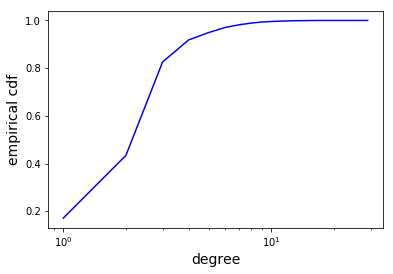

In [13]:
## degree distribution - North America Grid graph
deg = gr.degree()
e = ecdf(deg)
x = np.arange(1,30,1)
y = [e(i) for i in x]
plt.semilogx(x,y,'-',color='blue',label='Grid')
plt.xlabel('degree',fontsize=14)
plt.ylabel('empirical cdf',fontsize=14);
#plt.savefig('ecdf_gr.eps');

#### shortest path distribution

### Question 3 
### (P) In the original GitHub graph on 37,700 nodes,
### a. find the number of walks of length 5;
### b. find the number of cycles of length 4 (induced, that is, withoutchords).

In [8]:
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')

In [9]:
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed = False)

In [10]:
## add some node features, here there are
## 2 class of nodes, 0: web developer (red), 1: ml developer (blue)
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gh.vs['target'] = list(X['ml_target'])
cls = ['grey','black']
lbl = ['web','ml']
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]
gh.es['color'] = 'grey'

In [11]:
import networkx as nx

In [12]:
G1=nx.Graph() #define G1
G1.add_edges_from(tuples)


In [13]:
#Creating Sparse Adjacency Matrix of the graph
A = nx.adjacency_matrix(G1)

In [14]:
#Extracting value of Aij^3 of the adjacency matrix to find the number of walks of legth 3 between set of nodes ij
A3 = A*A*A
#Summing the matrix to find the totalof all node pairs
print(A3.sum())

18710998112


# There are 18710998112 walks of legth 3

In [23]:
#Extracting all cycles from the graph
cycls_3 = [c for c in nx.cycle_basis(G1)]

In [25]:
cyc = [i for i in cycls_3 if len(i)>4]
len(cyc)

194626

### There are 194626 cycle of legth 4

### Question 4 
### (P) Consider the airport graph available in Datasets/Airport/airportdata.csv on  the  GitHub  repo  (the first 3  fields are respectively origin, destination, and number of passengers). This graph is weighted and directed; weight of a directed edge uv corresponds  to  the  number  of  passengers  traveling  from airport u to airport v.
#### a.plot the cumulative degree distribution (points (`;n`), where n`is the number of nodes of degree at least`1) in the log-log plot;  find the slope of the line obtained via linear regression;
#### b. find  the  busiest  airport;  node  of  the  maximum  total  degree(degin(v) + degout(v));
#### c. find the number of strongly connected components;
#### d. find the subgraph induced by all airports from California;  find the number of isolated nodes in this subgraph

### Part a .plot the cumulative degree distribution (points (`;n`), where n`is the number of nodes of degree at least`1) in the log-log plot;  find the slope of the line obtained via linear regression;

In [14]:
#read airport data to dataframe
airport = pd.read_csv(datadir+'Airports/airport_data.csv')
airport.head()

,orig_airport,dest_airport,total_passengers,orig_lon,orig_lat,dest_lon,dest_lat,orig_state,dest_state,orig_city,dest_city
0,MHK,AMW,21,-96.670799,39.140999,-93.621803,41.992001,KS,IA,Manhattan,Ames
1,SEA,RDM,61274,-122.308998,47.449001,-121.150001,44.254101,WA,OR,Seattle,Bend
2,GEG,RDM,13,-117.533997,47.619900,-121.150001,44.254101,WA,OR,Spokane,Bend
3,AZA,RDM,2538,-111.654999,33.307800,-121.150001,44.254101,AZ,OR,Phoenix,Bend
4,BIL,RDM,100,-108.542999,45.807701,-121.150001,44.254101,MT,OR,Billings,Bend


In [15]:
#read the data from the airport dataframe to form tuples and graph
C = airport[['orig_airport', 'dest_airport', 'total_passengers']]
tuples1 = [tuple(x) for x in C.values]
ap = ig.Graph.TupleList(tuples1, directed = True, edge_attrs=['weight'])

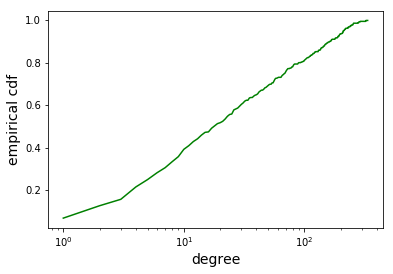

In [16]:
#degree distribution of the Airport Data
deg = ap.degree()
e = ecdf(deg)
x = np.arange(1,max(deg),1)
y = [e(i) for i in x]
plt.semilogx(x,y,'-',color='green',label='Grid')
plt.xlabel('degree',fontsize=14)
plt.ylabel('empirical cdf',fontsize=14);
#plt.savefig('ecdf_gr.eps');

In [17]:
## build dataframe with degrees and local clustering coefficients
## and compute mean values w.r.t. degree.
mindeg = 1
maxdeg = 100
D = pd.DataFrame(np.array([ap.transitivity_local_undirected(),ap.degree()]).transpose(),
            columns=['A','d'])

D = D.reset_index()
C = D[D['d']>mindeg].groupby(by='d').mean()
deg = list(C.index)
l = sum([i<=maxdeg for i in deg])
deg = deg[:l]
clust = list(C['A'])[:l]

power law exponent: 0.03605248058830326


Text(0, 0.5, 'log(mean local clust. coef.)')

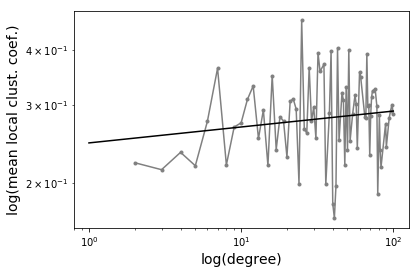

In [18]:
# Fit a regression (log-log scale) and plot
regressor = LinearRegression()  
x = [np.log(i) for i in deg]
y = [np.log(i) for i in clust]
regressor.fit(np.array(x).reshape(-1,1), y)
print('power law exponent:',regressor.coef_[0])
## plot on log-log scale
b = regressor.intercept_
a = regressor.coef_[0]
plt.loglog(deg,clust,'.-',color='grey')
plt.plot([mindeg,maxdeg],[np.exp(b)*mindeg**a,np.exp(b)*maxdeg**a],color='black')
plt.xlabel('log(degree)',fontsize=14)
plt.ylabel('log(mean local clust. coef.)',fontsize=14)
#plt.savefig('localCC.eps');

### The slope of the line is 0.036

### Part b. find  the  busiest  airport;  node  of  the  maximum  total  degree(degin(v) + degout(v));


In [19]:
#find the degree of the graph and then used np.max to find maximum degree
deg_ap = ap.degree()
k = np.max(deg_ap)
k

336

In [20]:
G = pd.DataFrame({'airport':ap.vs()['name'],\
                  'degree':ap.degree()})
## sort w.r.t. degree
Gs = G.sort_values(by='degree', ascending=False)
df = Gs.head()
df

,airport,degree
113,ATL,336
101,MSP,325
111,ORD,323
17,LAS,291
78,DFW,284


### Ans b = The  busiest  airport is ATL

### Part c. find the number of strongly connected components;

In [21]:
comp = np.max(ap.clusters().membership)+1
comp

40

### Ans c = The number of strongly connected components are 40

### Part d. find the subgraph induced by all airports from California;  find the number of isolated nodes in this subgraph

In [22]:
airport.head()

,orig_airport,dest_airport,total_passengers,orig_lon,orig_lat,dest_lon,dest_lat,orig_state,dest_state,orig_city,dest_city
0,MHK,AMW,21,-96.670799,39.140999,-93.621803,41.992001,KS,IA,Manhattan,Ames
1,SEA,RDM,61274,-122.308998,47.449001,-121.150001,44.254101,WA,OR,Seattle,Bend
2,GEG,RDM,13,-117.533997,47.619900,-121.150001,44.254101,WA,OR,Spokane,Bend
3,AZA,RDM,2538,-111.654999,33.307800,-121.150001,44.254101,AZ,OR,Phoenix,Bend
4,BIL,RDM,100,-108.542999,45.807701,-121.150001,44.254101,MT,OR,Billings,Bend


In [23]:
#making dataframe "C" by taking only the below three columns from the airport dataframe
C = airport[['orig_airport', 'orig_lon', 'orig_lat', 'orig_state']]
#C.head()

In [24]:
#making dataframe "E" by taking orig_state as CA.
ca_state = airport[airport['orig_state']=="CA"]
E = pd.DataFrame(ca_state)
E.head()

,orig_airport,dest_airport,total_passengers,orig_lon,orig_lat,dest_lon,dest_lat,orig_state,dest_state,orig_city,dest_city
12,SFO,RDM,22372,-122.375000,37.618999,-121.150001,44.254101,CA,OR,San Francisco,Bend
14,SAN,RDM,140,-117.190002,32.733601,-121.150001,44.254101,CA,OR,San Diego,Bend
18,STS,RDM,73,-122.813003,38.508999,-121.150001,44.254101,CA,OR,Santa Rosa,Bend
20,LAX,RDM,23486,-118.407997,33.942501,-121.150001,44.254101,CA,OR,Los Angeles,Bend
22,OAK,EKO,161,-122.221001,37.721298,-115.792000,40.824902,CA,NV,Oakland,Elko


In [25]:
C1 = E[['orig_airport', 'dest_airport', 'total_passengers']]
tuples2 = [tuple(x) for x in C1.values]
ap1 = ig.Graph.TupleList(tuples2, directed = True, edge_attrs=['weight'])

en_orgi_airport = {a:b for b,a in enumerate(airport['orig_airport'])}
l = [en_orgi_airport[x] for x in ap1.vs()['name']]

ap1.vs()['layout'] = [(airport['orig_lon'][i],airport['orig_lat'][i]) for i in l]
ap1.vs()['orig_state'] = [airport['orig_state'][i] for i in l]
## added a few more attributes for visualization
ap1.vs()['size'] = 4
ap1.vs()['color'] = 'black'
ap1.es()['color'] = 'grey'
ap1.es()['arrow_size'] = 0.50

In [26]:
## Build a subgraph for California as orig_state
hva = [v for v in ap1.vs() if v['orig_state'] == 'CA']
G = ap1.subgraph(hva)
G.vcount()

30

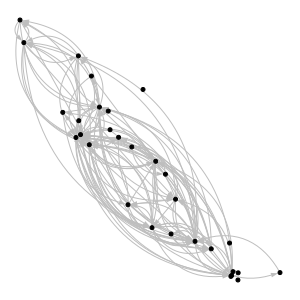

In [27]:
ly = ig.Layout(G.vs['layout'])
ly.mirror(1)
ig.plot(G, bbox=(0,0,300,300), layout=ly)

In [28]:
# G1 is the subgraph of nodes with degree equal to zero so those are isolated nodes
G1 = G.subgraph([v for v in G.vs() if v.degree()== 0])
G1.vcount()

8

### Ans d The total number of isolated nodes in the California subgraph are 8

### Question 5 
### (P) Take 100 random pairs of nodes in the European Grid network.For  each  pair  plot  a  point  (x;y),  where x is  the  graph  distance between  the  two  nodes  and y is  the  corresponding  geographical distance (in kilometres). Is there a correlation between the two distances?

In [36]:
## read edge list for the grid network
gr = ig.Graph.Read_Ncol(datadir+'GridEurope/gridkit_europe-highvoltage.edges', directed=False)
gr = gr.simplify()

## read the vertices along with some attributes
X = pd.read_csv(datadir+'GridEurope/gridkit_europe-highvoltage.vertices')
idx = [int(i) for i in gr.vs['name']]

sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)

sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr.vs['longitude'] = list(X['lon'])
gr.vs['latitude'] = list(X['lat'])
gr.vs['type'] = list(X['typ'])
gr.vs['layout'] = [(v['longitude'],v['latitude']) for v in gr.vs()]
gr.vs['size'] = 3
gr.es['color'] = 'grey'
gr.vs['color'] = 'black'

In [37]:
from pandas import DataFrame
import random
#generate 200 sample of vertices
sample = random.sample(range(gr.vcount()), 200)
df2 = X.reset_index()
#creating two lists with 100 samples in each list
node1 = sample[:100]
node2 = sample[100:200]
df = DataFrame(node1, columns = ['Node1'])
df['Node2']= node2
#find graph distance using shortest_paths_dijkstra
df['Graph_distance'] = df.apply(lambda x: gr.shortest_paths_dijkstra(x['Node1'],x['Node2']),axis=1)
df['Graph_distance'] = df['Graph_distance'].astype('str').apply(lambda x: x.replace('[','').replace(']','')) 
df3 = df.merge(df2[['index', 'lon', 'lat']], left_on = 'Node1', right_on = 'index')
df3 = df3.merge(df2[['index', 'lon', 'lat']], left_on = 'Node2', right_on = 'index')

#adopted the below function from slightly modified version: of http://stackoverflow.com/a/29546836/2901002
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
   
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


dist = haversine(df3.lat_x, df3.lon_y,
                 df3.lon_x, df3.lon_y)

df3['Geographic_distance'] = dist
df3['Graph_distance'] = df3['Graph_distance'].apply(pd.to_numeric, errors='coerce')

In [38]:
df3['Graph_distance'].corr(df3['Geographic_distance'])

nan

In [39]:
df3.corr()

,Node1,Node2,Graph_distance,index_x,lon_x,lat_x,index_y,lon_y,lat_y,Geographic_distance
Node1,1.000000,-0.080614,-0.290861,1.000000,-0.129182,-0.060964,-0.080614,-0.033077,-0.038497,0.103203
Node2,-0.080614,1.000000,-0.069468,-0.080614,0.070971,-0.031557,1.000000,-0.079406,-0.029071,-0.079956
Graph_distance,-0.290861,-0.069468,1.000000,-0.290861,-0.064566,-0.074734,-0.069468,0.049985,0.047306,0.040361
index_x,1.000000,-0.080614,-0.290861,1.000000,-0.129182,-0.060964,-0.080614,-0.033077,-0.038497,0.103203
lon_x,-0.129182,0.070971,-0.064566,-0.129182,1.000000,0.218232,0.070971,0.122262,0.105875,-0.922001
lat_x,-0.060964,-0.031557,-0.074734,-0.060964,0.218232,1.000000,-0.031557,-0.071725,0.055995,0.175461
index_y,-0.080614,1.000000,-0.069468,-0.080614,0.070971,-0.031557,1.000000,-0.079406,-0.029071,-0.079956
lon_y,-0.033077,-0.079406,0.049985,-0.033077,0.122262,-0.071725,-0.079406,1.000000,0.279851,-0.153894
lat_y,-0.038497,-0.029071,0.047306,-0.038497,0.105875,0.055995,-0.029071,0.279851,1.000000,-0.086414
Geographic_distance,0.103203,-0.079956,0.040361,0.103203,-0.922001,0.175461,-0.079956,-0.153894,-0.086414,1.000000


### Ans 5  There is no correlation between the two distances